In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dotenv import load_dotenv

#for filling missing values in the dataframe:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#custom tools created to bulk out the dataframe and plot results (see scripts folder):
from data_processing import phone_a_friend
from ui_tools import plot_stations

===== THE UNSUPERVISED MACHINE LEARNING PROBLEM ==============

The goal of this application is to discover the microclimates in Washington state for a given month from the public information from NOAA weatherstations:
(see https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C00823/html) (REF)

The purpose of doing so allows us to understand how the climate in areas of the state change with seasons and time, providing the capability to view progression of climates in locations in the region and granting forecasting capabilities when paired with a supervised model (not done here). This information is essential in recording the impact on regional climate from outside sources and provides a starting point for further evaluation.

To do so, we must first prepare a dataset that holds important information for differentiating between climates in the region.

Key parameters to consider when analyzing climate data include: ================================

station   : The unique identifier code for the weather station (e.g., GHCND:USW00094728)

datetime  : The date of the observation in YYYY-MM-DD format

PRCP      : Daily precipitation total (inches) -Some stations might be rain-only or have sensor issues, leading to missing values

SNOW      : Snowfall amount for the day (inches)

SNWD      : Snow depth at the end of the day (inches)

TMAX      : Maximum temperature for the day (Fahrenheit)

TMIN      : Minimum temperature for the day (Fahrenheit)

latitude  : Latitude of the weather station in decimal degrees

longitude : Longitude of the weather station in decimal degrees

elevation : Elevation of the station in meters above sea level
x==============================================================

Unsupervised learning is used here to group the weather features into climate groups, defining clusters of weather patterns that behave different from one another. Once this is achieved the groups can be labeled heuristically based on their characteristics. The resulting climate categories are then overlaid on a map by their latitude and longitude and tagged for clarity.

Resulting datasets are stored as csv files under "data/processed" and can be generated and visualized using the main.py script. The datasets used in this jupyter notebook are copies of information gathered for 2/2024 (Winter file) and 7/2024 (Summer file) and only saved to JUPYTER_results in the "data/ref" directory. The purpose of this is to walk you through the EDA procedure (gathering and preparing data), formatting of the unsupervised learning model (k-clustering), and analysis of the products (naming clusters). To perform this automatically for an existing dataset in "data/raw" you can use main.py, or use main.py to pull information from NOAA (uses fetcher.py) on a specified year/month from the pop-up prompt to predict climates on. (NOTE: you must add your own NOAA API key to .env or system variables).

In [2]:
load_dotenv()
#this is the example file for the jupyter EDA and walkthrough. The main.py (in scripts) takes user input instead
JUPYTER_FILE_DIR = "../" + os.getenv("JUPYTER_FILE_DIR")
print(f'Loading file: {JUPYTER_FILE_DIR}...')
REF_DIR = "../" + os.getenv("REF_DIR")
df = pd.read_csv(JUPYTER_FILE_DIR)

df['datetime'] = pd.to_datetime(df['datetime']) #formatting
important_features = ['PRCP', 'SNOW', 'SNWD', 'TMIN', 'TMAX', 'elevation']
weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMIN', 'TMAX']

Loading file: ../data/ref/Washington_JUPYTER_WINTER.csv...


***************************************** START EDA ****************************************

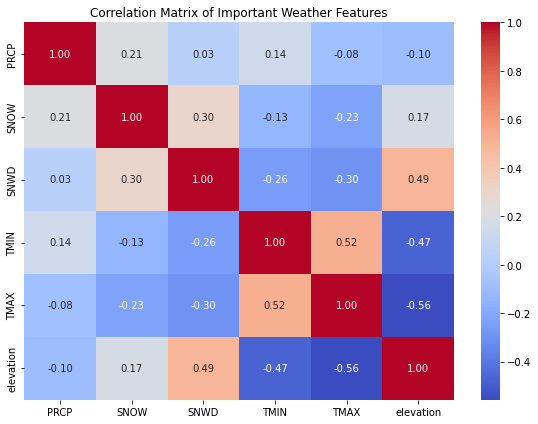

In [3]:
#first, lets see how the important features correlate to each other
full_df = df.dropna(subset=important_features) #reduce to rowes that are full
corr_matrix = full_df[important_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Important Weather Features")
plt.tight_layout()
plt.show()
before_corr = df.dropna(subset=important_features)[important_features].corr()

In [4]:
#The correlation matrix shows that (TMAX and TMIN), (SNWD and elevation), (elevation and temperature)
# are correlated (if the summer file in analyzzed, there may be no snow values)

#for TMAX and TMIN, we will use the mean of the station for the month to fill missing values before
#claiming that the station is missing the values (we assume temperatures dont fluctuate too much over the month)
df['TMAX'] = df.groupby('station')['TMAX'].transform(lambda x: x.fillna(x.mean()))
df['TMIN'] = df.groupby('station')['TMIN'].transform(lambda x: x.fillna(x.mean()))

In [5]:
#now lets fill the dataset out more by borrowing data from neighboring stations
#this allows us to impute values at each station using neighboring station data
df2 = phone_a_friend(df, max_km=40, max_ele_meters=100) #1km = 0.62 mi, 1m = 3.28ft

  0%|                                                                       | 0/623 [00:00<?, ?it/s]

Asking neighboring weather stations for missing data...



100%|████████████████████████████████████████████████████████████▉| 622/623 [03:11<00:00,  3.45it/s]


Total stations included: 623


In [6]:
df = df2.copy() #doing this so that we dont have to re-run phone_a_friend() if df is modified (takes a while)

#lets see what the correlation values look like now that data is borrowed from the neighboring stations
after_corr = df.dropna(subset=important_features)[important_features].corr()
delta_corr = after_corr - before_corr
print("\nChange in correlation coefficients after borrowing data from neighbors:")
print(delta_corr.round(2),'\n')


Change in correlation coefficients after borrowing data from neighbors:
           PRCP  SNOW  SNWD  TMIN  TMAX  elevation
PRCP       0.00 -0.01  0.01 -0.06 -0.03       0.02
SNOW      -0.01  0.00 -0.01 -0.05  0.00      -0.02
SNWD       0.01 -0.01  0.00  0.04  0.05      -0.11
TMIN      -0.06 -0.05  0.04  0.00  0.05      -0.05
TMAX      -0.03  0.00  0.05  0.05  0.00      -0.01
elevation  0.02 -0.02 -0.11 -0.05 -0.01       0.00 



In [7]:
#They are pretty similar, so we can assume that this method is valid...
#now lets check how many stations have the appropriate features for analysis
grouped = df.groupby('station')
def has_data(col):
    return grouped[col].apply(lambda x: x.notna().any())
availability = pd.DataFrame({
    'PRCP': has_data('PRCP'),
    'SNOW': has_data('SNOW'),
    'SNWD': has_data('SNWD'),
    'TMAX': has_data('TMIN'),
    'TMIN': has_data('TMAX')
})
availability['signature'] = availability.apply(lambda row: ''.join(['1' if row[c] else '0' for c in ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']]), axis=1)
combo_counts = availability['signature'].value_counts().sort_index()
def decode(sig):
    labels = weather_columns
    return ', '.join([label for i, label in enumerate(labels) if sig[i] == '1']) or 'None'
print("Unique data availability combinations:")
for sig, count in combo_counts.items():
    print(f"{sig} -> {decode(sig)}: {count} stations")

Unique data availability combinations:
00011 -> TMIN, TMAX: 26 stations
00111 -> SNWD, TMIN, TMAX: 3 stations
10000 -> PRCP: 11 stations
10011 -> PRCP, TMIN, TMAX: 15 stations
10111 -> PRCP, SNWD, TMIN, TMAX: 70 stations
11000 -> PRCP, SNOW: 52 stations
11011 -> PRCP, SNOW, TMIN, TMAX: 1 stations
11100 -> PRCP, SNOW, SNWD: 63 stations
11111 -> PRCP, SNOW, SNWD, TMIN, TMAX: 382 stations


In [8]:
#time to drop stations that dont have enough features (stations that have at least 4 readings can remain)
#Note: one reading is not shown on output: elevation, so if 3 features show above, then we keep them
#-Doing this because we will use an iterative imputer to fill missing values, and we need enough
#information to make the imputation as "accurate" as possible

df_sliced = df.dropna(subset=important_features, thresh=4)
print('stations remaining after reduction: ', len(df_sliced['station'].unique()))

grouped = df_sliced.groupby('station')
def has_data(col):
    return grouped[col].apply(lambda x: x.notna().any())
availability = pd.DataFrame({
    'PRCP': has_data('PRCP'),
    'SNOW': has_data('SNOW'),
    'SNWD': has_data('SNWD'),
    'TMAX': has_data('TMIN'),
    'TMIN': has_data('TMAX')
})
availability['signature'] = availability.apply(lambda row: ''.join(['1' if row[c] else '0' for c in ['PRCP', 'SNOW', 'SNWD', 'TMIN', 'TMAX']]), axis=1)
combo_counts = availability['signature'].value_counts().sort_index()
def decode(sig):
    labels = weather_columns
    return ', '.join([label for i, label in enumerate(labels) if sig[i] == '1']) or 'None'
print("\nUnique data availability combinations:")
for sig, count in combo_counts.items():
    print(f"{sig} -> {decode(sig)}: {count} stations")

stations remaining after reduction:  524

Unique data availability combinations:
00111 -> SNWD, TMIN, TMAX: 3 stations
10011 -> PRCP, TMIN, TMAX: 15 stations
10111 -> PRCP, SNWD, TMIN, TMAX: 70 stations
11011 -> PRCP, SNOW, TMIN, TMAX: 1 stations
11100 -> PRCP, SNOW, SNWD: 53 stations
11111 -> PRCP, SNOW, SNWD, TMIN, TMAX: 382 stations


In [9]:
#make sure each station has 15 or more days of information, if some do not, drop them
#stations that have less than 15 days of information do not represent the month with enough data

station_counts = df_sliced['station'].value_counts()
stations_to_keep = station_counts[station_counts >= 15].index
df_sliced = df_sliced[df_sliced['station'].isin(stations_to_keep)]
print('reduced to', df_sliced['station'].nunique(), 'stations (dropped stations with few entries)')

reduced to 485 stations (dropped stations with few entries)


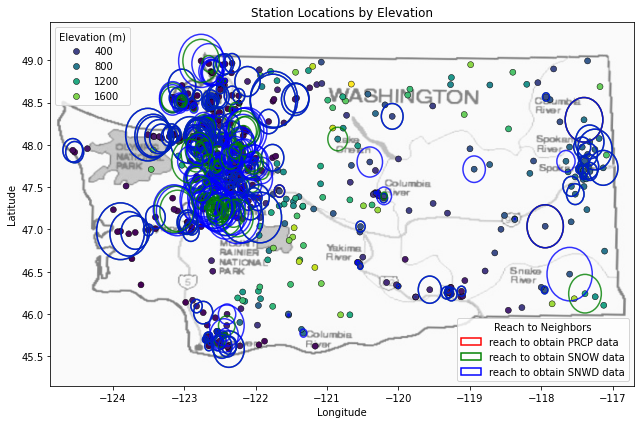

In [10]:
#how far did the stations reach out to get their data if needed from a neighbor?
#This is a tool I added to visualize how far (radius) stations need to reach to obtain
#a certain missing value (see key). Recall that the maximum radius and elevation reach is
#specified in phone_a_friend(df, max_km=X, max_ele_meters=X)

plot_stations(df_sliced,rings=True,image_path="../images/washington-state-map.jpg")

In [13]:
#we can see there are still missing values in the dataset, so we will need to impute them
#IterativeImputer is a powerful imputer that uses a model to predict missing values based on the trends 
#between features we will use this because the correlation matrix confirmed such trends

impute_df = df_sliced[important_features].copy()
imputer = IterativeImputer(random_state=42, max_iter=10)
imputed_array = imputer.fit_transform(impute_df)
df_sliced.loc[:, important_features] = pd.DataFrame(imputed_array, columns=important_features, index=impute_df.index)
print(f"All missing data in stations imputed\n")
#lets see what the correlation values look like now that data is borrowed from the neighboring stations
after_corr = df_sliced.dropna(subset=important_features)[important_features].corr()
delta_corr = after_corr - before_corr
print("Change in correlation coefficients from the original set after imputation:")
print(delta_corr.round(2))


All missing data in stations imputed

Change in correlation coefficients from the original set after imputation:
           PRCP  SNOW  SNWD  TMIN  TMAX  elevation
PRCP       0.00  0.11  0.20 -0.15 -0.09       0.19
SNOW       0.11  0.00  0.46 -0.32 -0.33       0.43
SNWD       0.20  0.46  0.00 -0.23 -0.32       0.29
TMIN      -0.15 -0.32 -0.23  0.00  0.18      -0.17
TMAX      -0.09 -0.33 -0.32  0.18  0.00      -0.21
elevation  0.19  0.43  0.29 -0.17 -0.21       0.00


In [11]:
#Check that the delta in correlation coefficients is logical. Many changes to the coefficients show
#what we would expect, such as SNOW and PRCP correlation getting stronger while SNOW and TMAX
#becoming more negatively correlated. This imputation strengthened the patterns we were already seeing.

#lets check if these values are realistic for the season:
snow_positive_count = df_sliced[df_sliced['SNOW'] > 0].shape[0]
snow_depth_positive_count = df_sliced[df_sliced['SNWD'] > 0].shape[0]
print(f'current data from {JUPYTER_FILE_DIR}')
print(f"\nNumber of entries where SNOW > 0: {snow_positive_count} of {df_sliced.shape[0]}")
print(f"Number of entries where SNWD > 0: {snow_depth_positive_count} of {df_sliced.shape[0]}")

#it is to be expected to see many SNOW/SNWD counts in winter and fewer in the summer.
#NOTE: A "Washington_EDA_SUMMER" file is included if you'd like to re-run the jupyter (just change .env variable)

current data from ../data/ref/Washington_JUPYTER_WINTER.csv

Number of entries where SNOW > 0: 889 of 13210
Number of entries where SNWD > 0: 3562 of 13210


100%|█████████████████████████████████████████████████████████████| 623/623 [12:59<00:00,  1.25s/it]


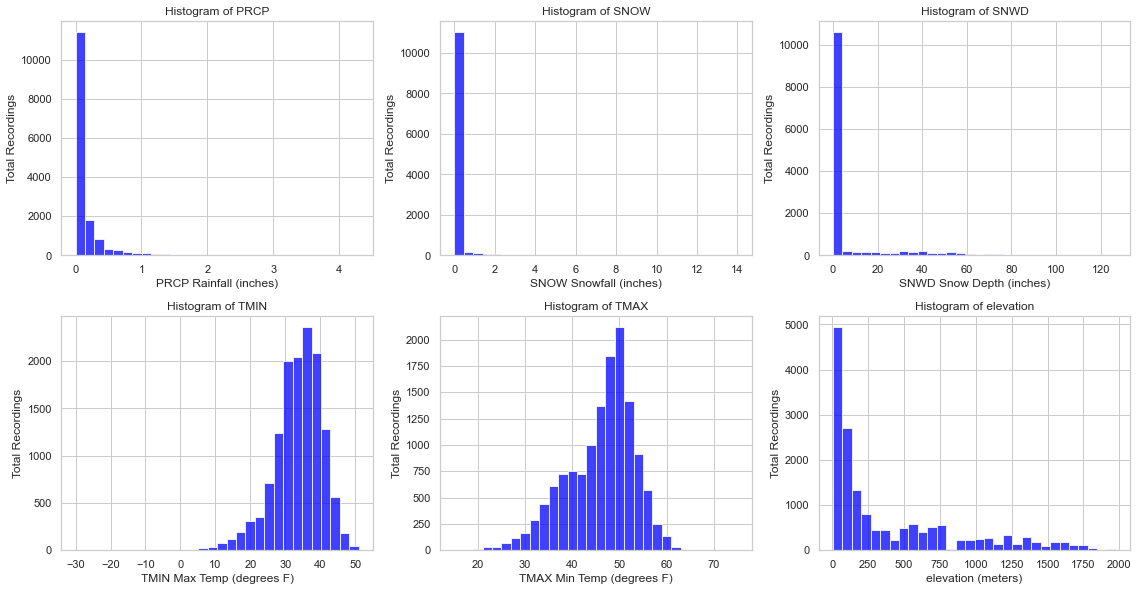

In [12]:
#lets lay out the data in a histogram to see if there are any outliers
sns.set_theme(style="whitegrid")
num_features = len(important_features)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
axes = axes.flatten()

units = ["Rainfall (inches)","Snowfall (inches)","Snow Depth (inches)","Max Temp (degrees F)","Min Temp (degrees F)","(meters)"]
for i, feature in enumerate(important_features):
    sns.histplot(df[feature], bins=30, ax=axes[i], color='blue')
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature + " " + units[i])
    axes[i].set_ylabel("Total Recordings")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

#you should not see any outliers, because NOAA releases accurate readings ;)

The visuals of the data show that there are no major outliers of concern
Now that the data is prepared and cleaned we will aggregate features to make the data
easier for a model to handle; reducing noise and complexity:

Regional climate clustering can be achieved using values that capture trends of the time period: ======

mean_TMAX	- Avg high temp for the month

mean_TMIN	- Avg low temp for the month

std_TMAX	- Temp variation

frost_days - Days where TMIN < 32F

total_PRCP - Total rainfall for the month

snow_days	Days with SNOW > 0 — captures snowy areas

PRCP_days	Days with rain > 0 — captures wet climate areas

elevation	(keep)
x============================================================

Not only does this feature format allow the clusters to be grouped easier, it also makes labeling the
clusters easier as we explore later

In [14]:
#With the above features, a well rounded dataset may look something like:
#| station_id | mean_TMAX | mean_TMIN | std_TMAX | frost_days | total_PRCP | snow_days | elevation |
#time to aggregate:

df_agg = df_sliced.groupby('station').agg(
    mean_TMAX=('TMAX', 'mean'),
    std_TMAX=('TMAX', 'std'),
    mean_TMIN=('TMIN', 'mean'),
    total_PRCP=('PRCP', 'sum'),
    PRCP_days=('PRCP', lambda x: (x > 0.25).sum()), #rainy days (not just a sprinkle)
    snow_days=('SNOW', lambda x: (x > 0).sum()), #snowing days
    frost_days=('TMAX', lambda x: (x < 32).sum()), #days below freezing
    elevation=('elevation', 'first')
)

df_agg.columns = ['mean_TMAX','std_TMAX','mean_TMIN','total_PRCP',
                  'PRCP_days','snow_days','frost_days','elevation']

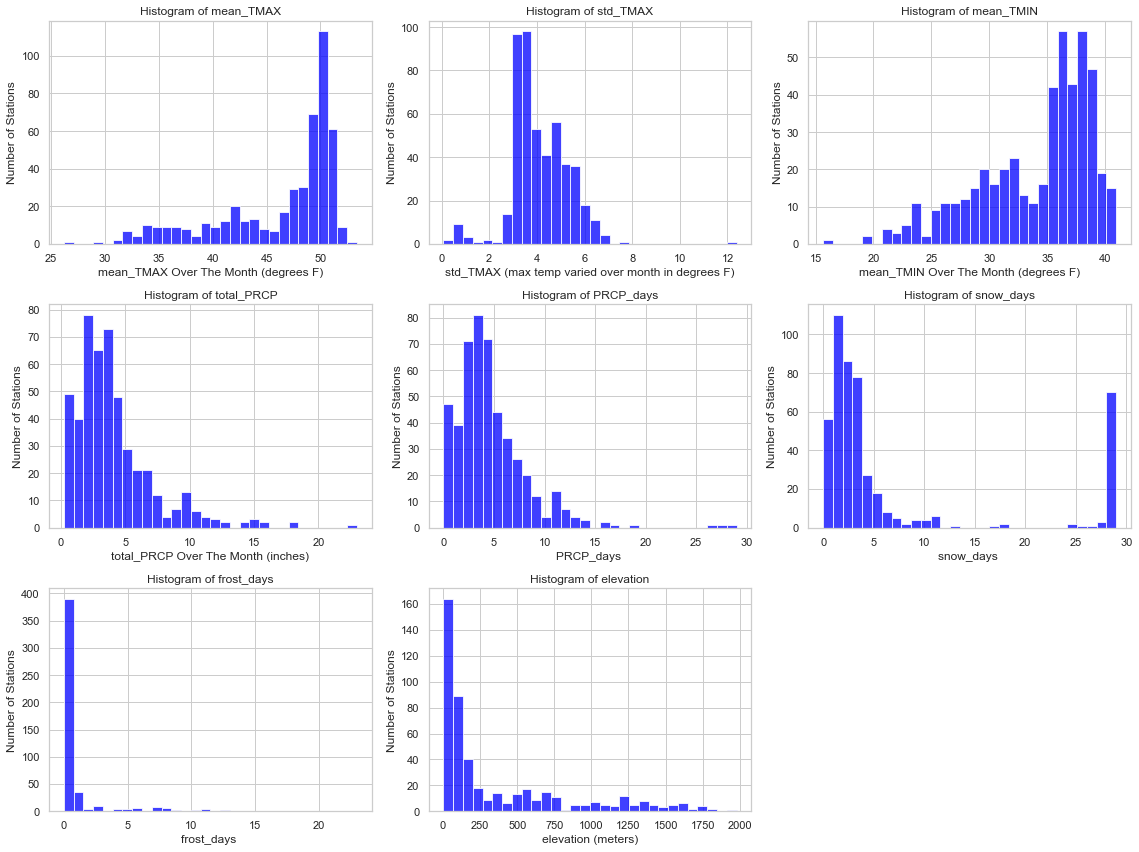

In [15]:
#plot another histogram of the aggregated data for reference (as seen, there should be no illogical outliers)
sns.set_theme(style="whitegrid")
num_features = len(df_agg.columns)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
axes = axes.flatten()

units = ["Over The Month (degrees F)","(max temp varied over month in degrees F)",
         "Over The Month (degrees F)", "Over The Month (inches)", "","","","(meters)"]
for i, feature in enumerate(df_agg.columns):
    sns.histplot(df_agg[feature], bins=30, ax=axes[i], color='blue')
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature + " " + units[i])
    axes[i].set_ylabel("Number of Stations")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

df_agg = df_agg.reset_index()

========================= CLUSTERING ==========================

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

#Standardize the data so that we can use it in a model
df_features = df_agg.drop(columns=['station'])
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)

To find the climates available from our dataset, we cannot use a supervised learning method because there are no existing climate types to draw a relationship from. Therefore, we must use an unsupervised method to gather the data into clusters for labeling.

Recall that the dataframe has the following features at this point:
| station_id | mean_TMAX | mean_TMIN | std_TMAX | frost_days | total_PRCP | snow_days |

Kmeans is the most appropriate model for the task because it is fast, scalable, and balances clusters by distance. This makes it ideal for our situation because it means that we can easily drop outliers based off of distance to improve the overall performance (measured by silhouette score). Additionally, we can find characteristics to represent the clusters (climates) simply by gatering the data defining their centroids.

Although Kmeans has some downsides- such as feature scaling and the need for a specific number of clusters must be chosen prior via analysis (inertia and silohette score), the time taken to do this (when automated as we do so with choose_best_k_combined() function below) outweighs the disadvantages of other clustering methods; particularly when it comes to simplicity and interpretability.

KMeans optimizes cluster centroids iteratively by minimizing the distance between points and their assigned centroids, therefore, for this project I set the hyperparameters to suit:

max_iter is set above 300: this ensures that even if convergence on the resulting clusters is slow, ther is no chance that we stop before the clustering results are solid.

n_init is set to 100: this is to test many more random clustering starting points than the default value of 10. This increases the chances to find the best solution.

In [17]:
#The unsupervised model being used is KMeans
inertia = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=100, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(df_scaled, kmeans.labels_))

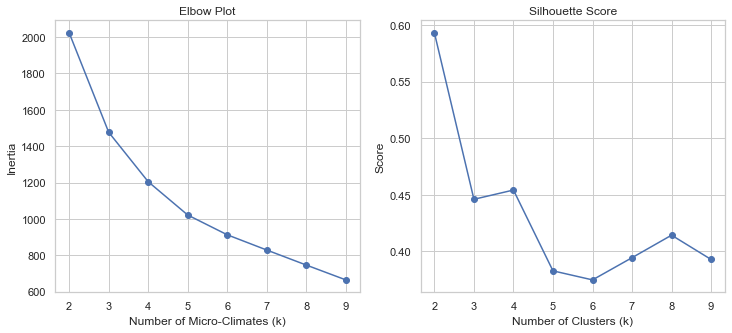

In [18]:
#this cell compares clusters to
# inertia (how tight the clusters are)
# silhouette score (how well each data point fits into its assigned cluster)
# to guide our decision on appropriate choice of n_clusters, we want a low inertia and high silhouette score

# Plot elbow and silhouette
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Plot')
plt.xlabel('Number of Micro-Climates (k)')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(K_range, sil_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.show()

Generally, the inertia and silhouette score will reduce as the number of clusters increase.
Recall: ====================================================

inertia (how tight the clusters are) - lower is better

silhouette score (how well each data point fits into its assigned cluster) - higher is better
x===========================================================

The best way to find a tradeoff is to incorporate the following: 
> Heuristically determine the minimum number of clusters. Washington state is a diverse region that holds many different climates (Experience: 26 years of living here). At any point of the year it is reasonable to assume that there will be >= 4 climate types in the entire state, but probably less than 8.

> The elbow method can be followed for "inertia" to pick a point where increasing the number of microclimates has diminishing return on decreasing the inertia.

> Keep a silhouette score that resides near this "elbow". If the silhouette score drops drastically at the elbow, it may be worth taking a lower cluster count value. Keeping a silhouette score past the elbow may result in too many meaningless clusters


In [19]:
#Here is a function to automatically predict the optimal k value:
from sklearn.preprocessing import MinMaxScaler

def choose_best_k_combined(inertia, sil_scores, K_range):
    inertia = inertia[K_range[0]-1:K_range[-1]]
    sil_scores = sil_scores[K_range[0]-1:K_range[-1]]

    #This function standardizes inertia and silhouette scores,
    #combines them by dividing silhouette by inertia,
    #selects the k with the maximum combined score.
    inertia = np.array(inertia).reshape(-1, 1)
    sil_scores = np.array(sil_scores).reshape(-1, 1)

    #standardize both to 0–1 range
    scaler = MinMaxScaler()
    inertia_std = scaler.fit_transform(inertia).flatten()
    sil_std = scaler.fit_transform(sil_scores).flatten()

    #lower inertia is better, so we invert it (1 - inertia)
    inertia_std_inverted = np.clip(1 - inertia_std, 1e-6, 1)

    #calculate combined score
    combined_score = sil_std / inertia_std_inverted
    #print(combined_score)
    #pick the best k (where combined score is max)
    best_index = np.argmax(combined_score)
    best_k = K_range[best_index]

    print(f"Best number of clusters based on combined score: {best_k}")

    return best_k
#notice k initially ranges from 4 to 7 using the heuristic approach
best_k = choose_best_k_combined(inertia, sil_scores, range(4,9))

Best number of clusters based on combined score: 4


Silhouette Score (initial): 0.4542829489504735 for 485 stations


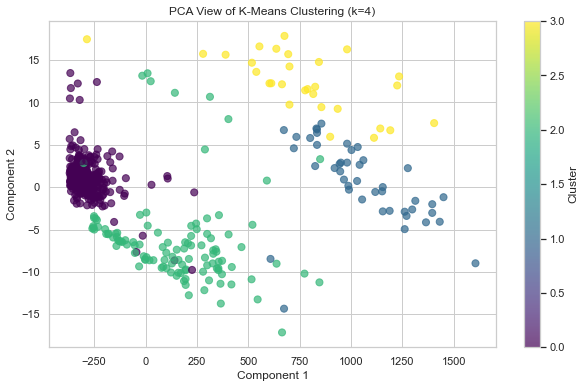

In [20]:

#train a KMeans model on the number of cluster that seem logical (or result from the function above)

num_k = best_k #number of clusters (change this value if you'd like)
kmeans = KMeans(n_clusters=num_k, max_iter=1000, n_init=100, random_state=42)

#start consolidating final info------------------------------------
df_loc = df_sliced.groupby('station').agg(latitude=('latitude', 'first'),
                                   longitude=('longitude', 'first'),
                                   elevation=('elevation', 'first')
                                   ).reset_index(drop=True)
df_final = df_agg['station'].to_frame().copy()
df_final = pd.concat([df_final,
                      pd.DataFrame({'cluster':kmeans.fit_predict(df_scaled)}),
                      df_loc],axis=1)

#print(df_final)
initial_clustering_labels = df_final['cluster'].copy()

#--------------------------------------------------------------------------------
#performance of clustering method
sil_score = silhouette_score(df_scaled, initial_clustering_labels)
print(f"Silhouette Score (initial): {sil_score} for {df_final.shape[0]} stations")

#-------------------------------------------plot PCA to observe results of clustering
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_features)

plt.figure(figsize=(10, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=initial_clustering_labels, cmap='viridis', s=50, alpha=0.7)
plt.title(f'PCA View of K-Means Clustering (k={num_k})')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster')
plt.show()


====================== ANALYSIS =========================

The silhouette score is decent, but not good enough. In this section we can start by reducing uncertainty/outliers in each cluster by determining a distance threshold that the data points must reside within using distance to the centroid of each cluster. If data points reside outside this threshold, they are dropped.

This threshold can be adjusted until a desired silhouette score is achieved (ie. 45), although increasing the silhouette score cutoff (via threshold) too far will result in sparse results. The key here is balance.

In [21]:
#Here is a function to automatically find the optimal threshold to achieve a specific silhouette score:
def reduce_outliers_kmeans(df_scaled,df_final,kmeans,sil_cutoff=0.5):
    for threshold in range(100,50,-1):  #cutoff for deleting cluster outliers (after clustering)
        centroids = kmeans.cluster_centers_
        distances = np.linalg.norm(df_scaled - centroids[df_final['cluster']], axis=1)
        cut_dist = np.percentile(distances, threshold) #Define threshold to cut at

        remaining_stations = distances < cut_dist #Filter out outliers
        df_scaled_clean = df_scaled[remaining_stations]
        df_final_clean = df_final[remaining_stations].reset_index(drop=True)

        cleaned_clustering_labels = df_final_clean['cluster']
        sil_score_clean = silhouette_score(df_scaled_clean, cleaned_clustering_labels)
        
        if sil_score_clean > sil_cutoff:
            return threshold
    #no ammount of cleaning can save this one:
    return threshold

sil_cutoff=0.5
optimal_threshold = reduce_outliers_kmeans(df_scaled,df_final,kmeans,sil_cutoff=sil_cutoff)
print(f'Threshold to achieve silhouette score of {sil_cutoff} is {optimal_threshold}')


Threshold to achieve silhouette score of 0.5 is 92


Silhouette Score (after removing outliers): 0.5031219002791318  for 446 stations


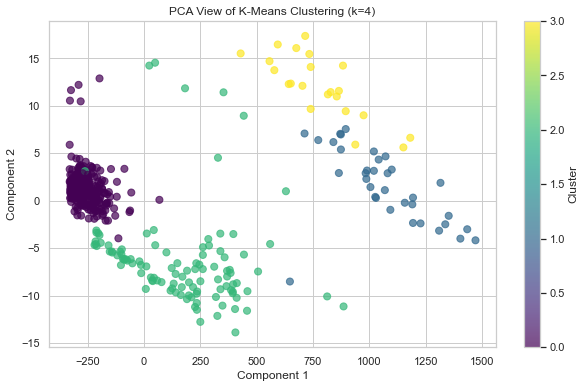

In [22]:
threshold =  optimal_threshold #cutoff for deleting cluster outliers (after clustering)

#----------------------------------------------------------------------
centroids = kmeans.cluster_centers_
distances = np.linalg.norm(df_scaled - centroids[df_final['cluster']], axis=1)
threshold = np.percentile(distances, threshold) #Define threshold to cut at

remaining_stations = distances < threshold #Filter out outliers
df_scaled_clean = df_scaled[remaining_stations]
df_final_clean = df_final[remaining_stations].reset_index(drop=True)
df_features_cleaned = df_features[remaining_stations]
#print(df_final)

cleaned_clustering_labels = df_final_clean['cluster']
#--------------------------------------------------------------------------------
sil_score_clean = silhouette_score(df_scaled_clean, cleaned_clustering_labels)
print(f"Silhouette Score (after removing outliers): {sil_score_clean}  for {df_final_clean.shape[0]} stations")

#-------------------------------------------plot PCA to observe results of removing outliers
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_features_cleaned)

plt.figure(figsize=(10, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=cleaned_clustering_labels, cmap='viridis', s=50, alpha=0.7)
plt.title(f'PCA View of K-Means Clustering (k={num_k})')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster')
plt.show()


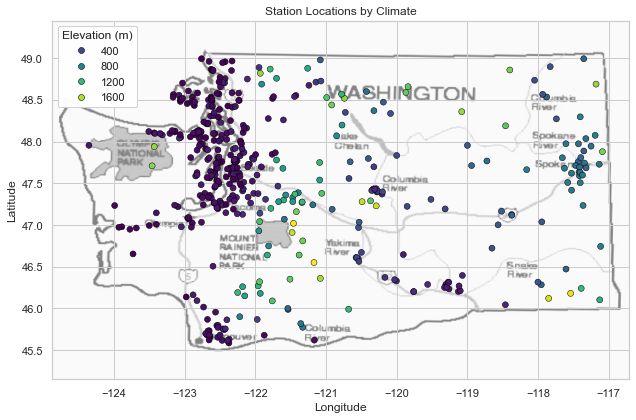

In [23]:
#plot cluster locations to see if they make sense
plot_stations(df_final_clean,image_path="../images/washington-state-map.jpg",rings=False,k=num_k)

In [26]:
#If the clusters show similarity throughout geography of the state, then we are on the right track
#Now, get cluster centers. These are values that represent the standard qualities of each feature
cluster_info_standardized = pd.DataFrame(kmeans.cluster_centers_, columns=df_features.columns)

#this function will label patterns between clusters
def score_to_label(val): #for relative visualization
    if val <= -1: return "very low"
    elif val <= -0.5: return "low"
    elif val >= 1: return "very high"
    elif val >= 0.5: return "high"
    else: return "mid"

#we need to bring the original scaling back in order to make the dataset readable
cluster_info_actual = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_),columns=df_features.columns)
cluster_info_actual['relative_elevation'] = cluster_info_standardized['elevation'].apply(score_to_label)
print(cluster_info_actual)

   mean_TMAX  std_TMAX  mean_TMIN  total_PRCP  PRCP_days  snow_days  \
0  49.739914  3.526091  37.240068    4.104934   4.299663   2.060606   
1  34.371293  5.253452  24.304859    4.734773   5.613636  28.090909   
2  44.353583  5.103258  30.553776    1.700720   1.521739   5.000000   
3  37.566842  4.310026  29.720459   12.247734  14.172414  28.103448   

     frost_days    elevation relative_elevation  
0  2.442491e-15    85.823232                low  
1  7.909091e+00  1422.590909          very high  
2  2.608696e-01   517.033043                mid  
3  3.275862e+00  1141.810345          very high  


The clusters for this month can be grouped into microclimates for our region using a heuristic approach. In this approach we return the climate for the cluster by assigning each feature within the cluster a descriptive label and returning the concatenated descriptors.

This gives the user a good idea of what makes this cluster unique.

======================== LABEL THE CLUSTERS =========================

In [33]:
def label_climate(row):
    tmax = row['mean_TMAX']
    tmin = row['mean_TMIN']
    prcp = row['total_PRCP']
    prcp_days = row['PRCP_days']
    snow_days = row['snow_days']
    frost_days = row['frost_days']
    elevation = row['elevation']
    rel_elev = row['relative_elevation']
    
    avg_temp = (tmax + tmin) / 2
    sea_lvl = elevation < 200

    #create labels----------------------

    #temperance
    temptype = 'moderate'
    if frost_days > 20: temptype = 'frozen'
    elif avg_temp < 32: temptype = 'freezing'
    elif avg_temp < 40: temptype = 'very cold'
    elif avg_temp < 55: temptype = 'cold'
    elif avg_temp > 72: temptype = 'hot'
    elif avg_temp > 65: temptype = 'warm'

    #moisture
    precip_type = ''
    if snow_days > 10: precip_type = 'snowy'
    elif prcp_days > 10: precip_type = 'rainy'
    elif prcp < 1: precip_type = 'very dry'
    elif prcp < 2.36: precip_type = 'dry'
    elif prcp > 9: precip_type = 'very wet'
    elif prcp > 6: precip_type = 'wet'

    #region type based on elevation
    region = 'midlands'
    if sea_lvl: region = 'costal'
    elif rel_elev in ['very low','low']: region = 'lowland'
    elif rel_elev == 'high': region = 'highland'
    elif rel_elev == 'very high': region = 'mountainous'

    #-------------concatenate---------
    if precip_type == '':
        return temptype + ' ' + region
    else:
        return temptype + ' ' + precip_type + ' ' + region

In [34]:
#apply labels to all stations/clusters
cluster_info_actual['microclimate_label'] = cluster_info_actual.apply(label_climate, axis=1)
cluster_to_climate = cluster_info_actual['microclimate_label'].to_dict()
df_final_clean['climate'] = df_final_clean['cluster'].map(cluster_to_climate)
num_unique_climates = df_final_clean['climate'].nunique()

============ MAP THE RESULTS ===============

This output map of Washington State is the result of the work done above. Thankfully (for those familiar with Washington) the application pipeline can be tuned by comparing the resulting graph with logic (for ballpark accuracy) and existing information/weather results stored online regarding the region at this time of year.

The resulting dataframe is then stored in the "data/ref" directory for the jupyter example and when main.py is run, it will be stored to "data/processed" for futre reference and/or further analysis (a supervised prediction model maybe?).

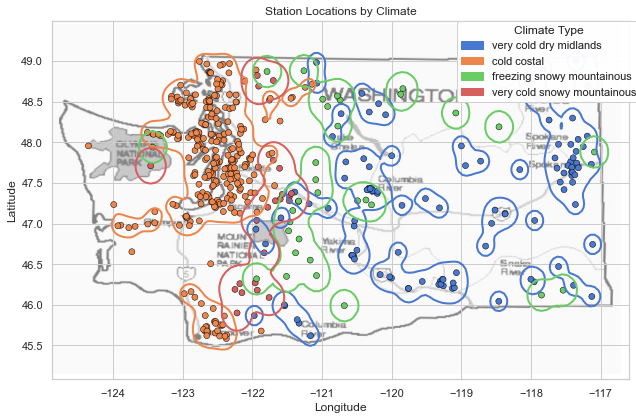

In [35]:
#plot climate locations
plot_stations(df_final_clean,image_path="../images/washington-state-map.jpg",rings=False,k=num_k,show_climates=True)

In [30]:
#when the results are done we can save the file to reference later or use in a supervised model

df_final_clean.to_csv(REF_DIR+'/JUPYTER_results.csv', index=False)